# Result ID regression

In [1]:
#import warnings
#warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [2]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
import numpy as np
import yaml

from vessel_manoeuvring_models.visualization.plot import track_plot, plot
from phd.visualization.plot_ship import track_plots
from vessel_manoeuvring_models.prime_system import PrimeSystem
from phd.visualization.plot_prediction import plot_total_force, plot_force_components, predict, plot_compare_model_forces, plot_parameter_contributions, group_parameters, joined_parameter_contributions, same_ylims
from vessel_manoeuvring_models.symbols import *
import matplotlib.pyplot as plt
from vessel_manoeuvring_models.substitute_dynamic_symbols import run, lambdify, remove_functions, prime
from vessel_manoeuvring_models.parameters import df_parameters
p = df_parameters["symbol"]
import statsmodels.api as sm
import sympy as sp
from sympy import Eq, symbols, latex
import paper
from paper import save_fig, save_eq
import yaml
with open("styles.yml", mode='r') as file:
    styles = yaml.safe_load(file)
from phd.pipelines.predict.nodes import score
import vessel_manoeuvring_models.models.IMO_simulations

In [3]:
#%reload_kedro
ship='wPCC'
ship_data = catalog.load(f"{ship}.ship_data")

df_VCT = catalog.load(f"{ship}.df_VCT")
resistance_MDL = catalog.load(f"{ship}.resistance_MDL")
tests_ek_smooth = catalog.load(f"{ship}.tests_ek_smooth")
tests_ek = catalog.load(f"{ship}.tests_ek")

mask = ((df_VCT['Y_R_port'] > 0) & (df_VCT['test type'] == 'self propulsion'))
df_VCT = df_VCT.loc[~mask].copy()  ## remove duplicate self propulsion

time_series_meta_data = catalog.load(f"{ship}.time_series_meta_data")
#tests_ek_smooth_joined = catalog.load(f"{ship}.tests_ek_smooth_joined")
tests_ek_joined = catalog.load(f"{ship}.tests_ek_joined")

df_VCT = catalog.load(f"{ship}.df_VCT")
mask = ((df_VCT['Y_R_port'] > 0) & (df_VCT['test type'] == 'self propulsion'))
df_VCT = df_VCT.loc[~mask].copy()  ## remove duplicate self propulsion


[01/31/24 13:30:36] INFO     Loading data from 'wPCC.ship_data' (YAMLDataSet)...                ]8;id=305337;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=541913;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.df_VCT' (CSVDataSet)...                    ]8;id=136440;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=952598;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.resistance_MDL' (CSVDataSet)...            ]8;id=576838;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=515058;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.tests_ek_smooth' (PartitionedDataset)...   ]8;id=428712;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=579563;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.tests_ek' (PartitionedDataset)...          ]8;id=696744;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=750733;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.time_series_meta_data' (CSVDataSet)...     ]8;id=712290;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=943350;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.tests_ek_joined' (CSVDataSet)...           ]8;id=586650;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=65641;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

[01/31/24 13:30:37] INFO     Loading data from 'wPCC.df_VCT' (CSVDataSet)...                    ]8;id=79785;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=300798;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

## MDL model tests

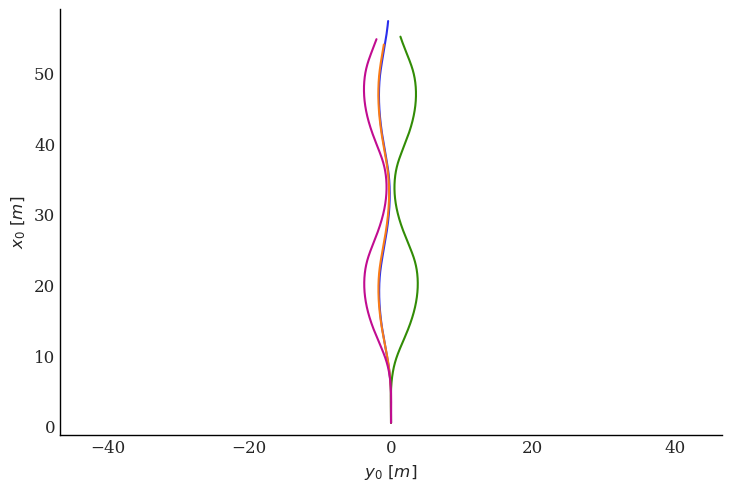

In [4]:
fig,ax=plt.subplots()

mask = tests_ek_joined['id'].isin([
    #22774,  # Circle
    #22611,
    #22635,
    #22639,
    22769,
    22771,
])

tests_ek_smooth_joined = tests_ek_joined.loc[~mask].copy()

for id, group in tests_ek_smooth_joined.groupby(by='id'):
    group[['x0','y0']].rolling(window=100).mean().plot(x='y0',y='x0', label=id, ax=ax)
ax.axis('equal')
ax.get_legend().set_visible(False)
ax.set_xlabel(r'$y_0$ $[m]$')
ax.set_ylabel(r'$x_0$ $[m]$')
fig.savefig(paper.file_path_with_nb_ref("model_tests.pdf"))

In [5]:
tests_ek_smooth_joined['id'].unique()

array([22765, 22770, 22772, 22773])

In [6]:
loaders = {
        
    'Reference model' : catalog.load(f"{ship}.models_VCT_MDL")['semiempirical_covered'],
    'Physics informed ID' : catalog.load(f"{ship}.models_ID_hull")['semiempirical_covered'],
    
    #'Abkowitz  VCT': catalog.load(f"{ship}.models_rudder_VCT_MDL")['Abkowitz'],
    'Abkowitz ID' : catalog.load(f"{ship}.models_ID_hull_rudder")['Abkowitz'],
}

                    WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/pa ]8;id=136707;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=118287;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rtitioned_dataset.py:200: KedroDeprecationWarning:                                    
                             'PartitionedDataset' has been moved to `kedro-datasets` and will be                   
                             removed in Kedro 0.19.0.                                                              
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/__ ]8;id=708296;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=147758;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             init__.py:44: KedroDeprecationWarning: 'AbstractDataSet' has been                     
                             renamed to 'AbstractDataset', and the alias will be removed in Kedro                  
                             0.19.0                                                                                
                               return getattr(kedro.io.core, name)                                                 
                                                                                                                   

                    INFO     Loading data from 'wPCC.models_VCT_MDL' (PartitionedDataset)...    ]8;id=963582;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=475597;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.models_ID_hull' (PartitionedDataset)...    ]8;id=554141;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=346755;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.models_ID_hull_rudder'                     ]8;id=491264;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=603886;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

In [7]:
models = {name:loader() for name,loader in loaders.items()}

## Experiment

In [8]:
#id = 22765
#id = 22770
id = 22772
#id = 22773

#data_MDL = tests_ek[f'{id}']()
data_MDL = tests_ek_smooth[f'{id}']()

data_MDL['V'] = data_MDL['U'] = np.sqrt(data_MDL['u']**2 + data_MDL['v']**2)
data_MDL['beta'] = -np.arctan2(data_MDL['v'],data_MDL['u'])
data_MDL['rev'] = data_MDL[['Prop/PS/Rpm','Prop/SB/Rpm']].mean(axis=1)
data_MDL['twa']=0
data_MDL['tws']=0
data_MDL['theta']=0
data_MDL['q']=0
data_MDL['phi'] = data_MDL['roll']
data_MDL['p'] = 0
data_MDL['q1d'] = 0
data_MDL['thrust_port'] = data_MDL['Prop/PS/Thrust']
data_MDL['thrust_stbd'] = data_MDL['Prop/SB/Thrust']
data_MDL['thrust'] = data_MDL['thrust_port'] + data_MDL['thrust_stbd']
data_MDL['beta_deg'] =  np.rad2deg(data_MDL['beta'])
data_MDL['psi_deg'] =  np.rad2deg(data_MDL['psi'])

# Remove the firs part:
dt = pd.Series(data_MDL.index).diff().mean()
rudder_rate = 2.32 * np.sqrt(ship_data["scale_factor"])
start = (data_MDL['delta'].diff().abs() > 0.5*np.deg2rad(rudder_rate)*dt).idxmax()
data_MDL.index = pd.Series(data_MDL.index) - start
data_MDL=data_MDL.loc[0:].copy()

[01/31/24 13:31:02] WARNING  /home/maa/dev/PHD/src/phd/visualization/plot_prediction.py:252:        ]8;id=445623;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=265881;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             UserWarning: The figure layout has changed to tight                                   
                               plt.tight_layout()                                                                  
                                                                                                                   

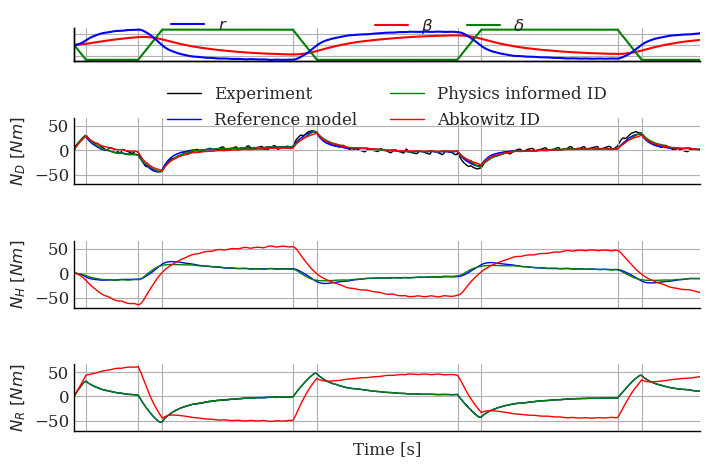

In [9]:
fig = plot_compare_model_forces(model=models['Reference model'], models=models, data=data_MDL, styles=styles, keys=['N_D','N_H','N_R'])
fig.axes[0].legend(loc='upper center', bbox_to_anchor=(0.6, 1.8), ncol=3)
fig.axes[4].legend(loc='upper center', bbox_to_anchor=(0.2, 1.8), ncol=1)
fig.axes[1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.7), ncol=2)
plt.tight_layout()

fig.savefig(paper.file_path_with_nb_ref("ID_regression_ID_N.pdf"))
fig.savefig(paper.file_path_with_nb_ref("ID_regression_ID_N.svg"))

[01/31/24 13:31:03] WARNING  /home/maa/dev/PHD/src/phd/visualization/plot_prediction.py:252:        ]8;id=469762;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=677025;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             UserWarning: The figure layout has changed to tight                                   
                               plt.tight_layout()                                                                  
                                                                                                                   

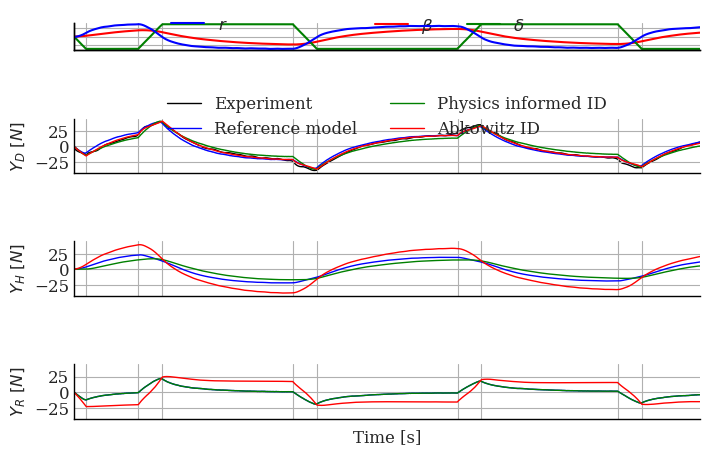

In [10]:
fig = plot_compare_model_forces(model=models['Reference model'], models=models, data=data_MDL, styles=styles, keys=['Y_D','Y_H','Y_R'])
fig.axes[0].legend(loc='upper center', bbox_to_anchor=(0.6, 1.8), ncol=3)
fig.axes[4].legend(loc='upper center', bbox_to_anchor=(0.2, 1.8), ncol=1)
fig.axes[1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.7), ncol=2)
plt.tight_layout()
fig.savefig(paper.file_path_with_nb_ref("ID_regression_ID_Y.pdf"))

## Parameter decomposition
The predicted forces can be decomposed into the various parameter contributions. It can be seen that the `model` and `Abkowitz` have very different decompositions, eventhough the simulations results above are similar. The contributions from the Nr and Nrrr coefficients are very large for the `Abkowitz`.

[01/31/24 13:31:04] WARNING  /tmp/ipykernel_4787/1639498869.py:15: UserWarning: The figure layout   ]8;id=378458;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=271087;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             has changed to tight                                                                  
                               plt.tight_layout()                                                                  
                                                                                                                   

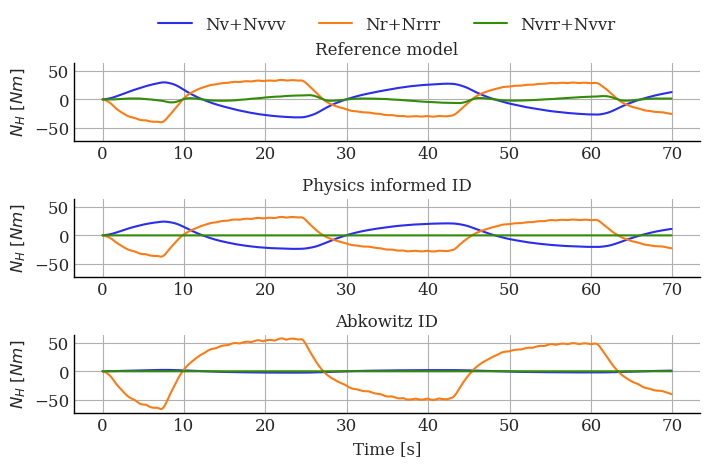

In [11]:
fig,axes=plt.subplots(nrows=len(models))

for ax, (name, model) in zip(axes,models.items()):
                      
    ax.set_title(name)
    plot_parameter_contributions(model=model, data=data_MDL, ax=ax, prefix='N', unit='moment')
    ax.grid(True)

same_ylims(axes)
    
for ax in axes[1:]:
    ax.get_legend().set_visible(False)

axes[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.8), ncol=3)
plt.tight_layout()
axes[-1].set_xlabel('Time [s]')

fig.savefig(paper.file_path_with_nb_ref("ID_regression_N_decomposition.pdf"))

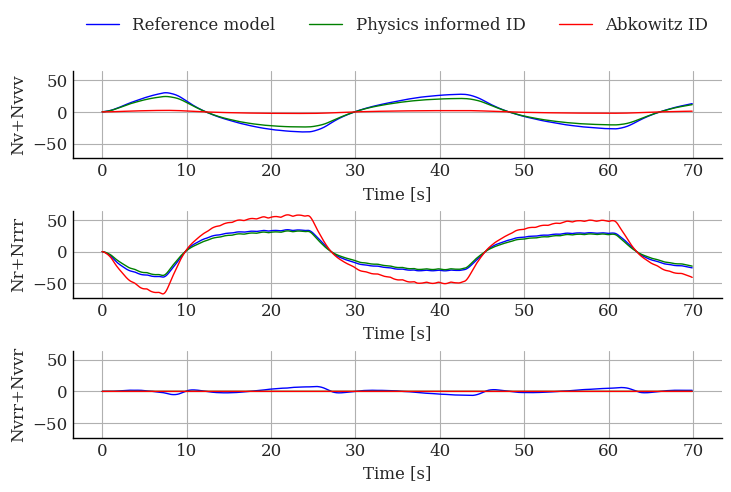

In [12]:
df_joined_parameter_contributions = joined_parameter_contributions(model=model, data=data_MDL, prefix='N', unit='moment')

fig,axes=plt.subplots(nrows=len(df_joined_parameter_contributions.columns))
for model_name,model in models.items():

    df_joined_parameter_contributions = joined_parameter_contributions(model=model, data=data_MDL, prefix='N', unit='moment')
    
    for ax,(group_name, values) in zip(axes,df_joined_parameter_contributions.items()):
        values.plot(ax=ax, **styles[model_name])
        ax.set_ylabel(group_name)
        ax.set_xlabel('Time [s]')
        ax.grid(True)

same_ylims(axes)

axes[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.8), ncol=3)

In [13]:
df_joined_parameter_contributions.columns

Index(['Nv+Nvvv', 'Nr+Nrrr', 'Nvrr+Nvvr'], dtype='object')

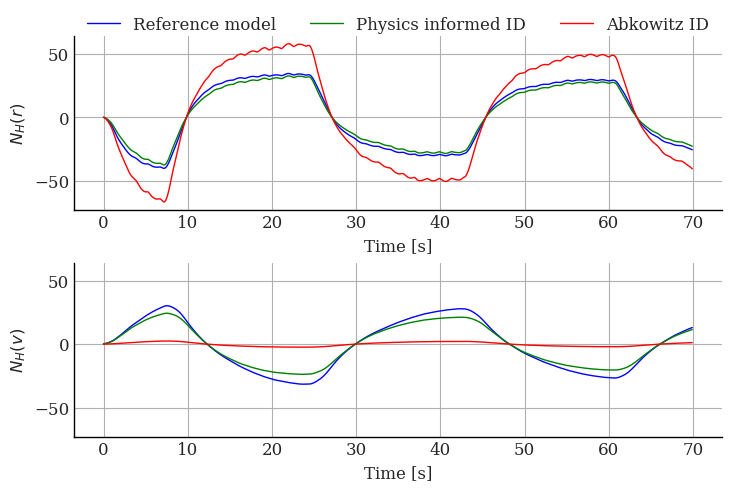

In [14]:
df_joined_parameter_contributions = joined_parameter_contributions(model=model, data=data_MDL, prefix='N', unit='moment')

df_joined_parameter_contributions.drop(columns=['Nvrr+Nvvr'], inplace=True)
renames = {
    'Nv+Nvvv':r'$N_H(v)$',
    'Nr+Nrrr':r'$N_H(r)$',
}
df_joined_parameter_contributions.rename(columns=renames, inplace=True)


fig,axes=plt.subplots(nrows=len(df_joined_parameter_contributions.columns))
for model_name,model in models.items():

    df_joined_parameter_contributions = joined_parameter_contributions(model=model, data=data_MDL, prefix='N', unit='moment')
    df_joined_parameter_contributions.drop(columns=['Nvrr+Nvvr'], inplace=True)
    renames = {
        'Nv+Nvvv':r'$N_H(v)$',
        'Nr+Nrrr':r'$N_H(r)$',
    }
    df_joined_parameter_contributions.rename(columns=renames, inplace=True)
    df_joined_parameter_contributions = df_joined_parameter_contributions[[r'$N_H(r)$',r'$N_H(v)$']].copy()
    
    for ax,(group_name, values) in zip(axes,df_joined_parameter_contributions.items()):
        values.plot(ax=ax, **styles[model_name])
        ax.set_ylabel(group_name)
        ax.set_xlabel('Time [s]')
        ax.grid(True)

same_ylims(axes)

axes[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3)
fig.savefig(paper.file_path_with_nb_ref("ID_regression_N_decomposition2.svg"))

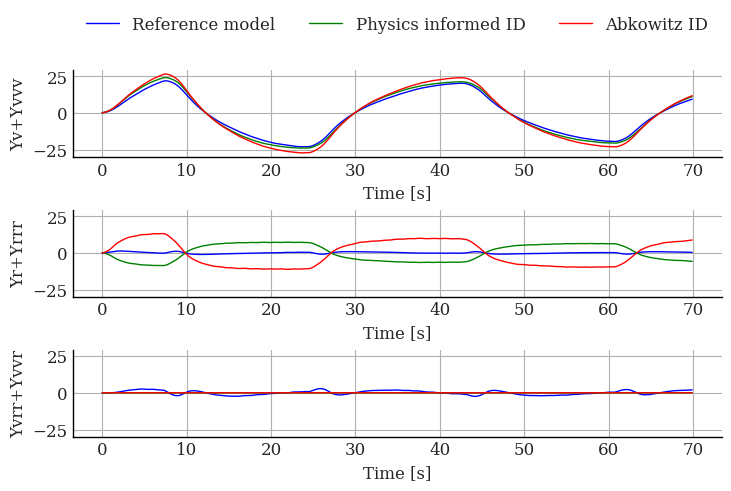

In [15]:
df_joined_parameter_contributions = joined_parameter_contributions(model=model, data=data_MDL, prefix='Y', unit='force')

fig,axes=plt.subplots(nrows=len(df_joined_parameter_contributions.columns))
for model_name,model in models.items():

    df_joined_parameter_contributions = joined_parameter_contributions(model=model, data=data_MDL, prefix='Y', unit='force')
    
    for ax,(group_name, values) in zip(axes,df_joined_parameter_contributions.items()):
        values.plot(ax=ax, **styles[model_name])
        ax.set_ylabel(group_name)
        ax.set_xlabel('Time [s]')
        ax.grid(True)

same_ylims(axes)

axes[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.8), ncol=3)

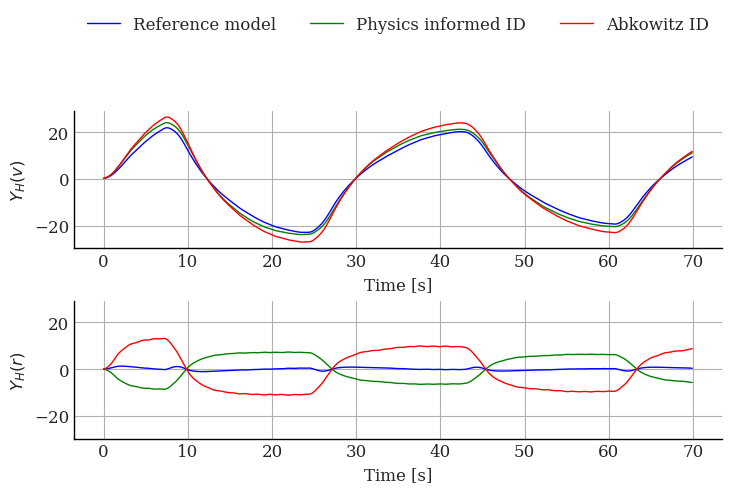

In [16]:
df_joined_parameter_contributions = joined_parameter_contributions(model=model, data=data_MDL, prefix='Y', unit='force')

df_joined_parameter_contributions.drop(columns=['Yvrr+Yvvr'], inplace=True)
renames = {
    'Yv+Yvvv':r'$Y_H(v)$',
    'Yr+Yrrr':r'$Y_H(r)$',
}
df_joined_parameter_contributions.rename(columns=renames, inplace=True)


fig,axes=plt.subplots(nrows=len(df_joined_parameter_contributions.columns))
for model_name,model in models.items():

    df_joined_parameter_contributions = joined_parameter_contributions(model=model, data=data_MDL, prefix='Y', unit='force')
    df_joined_parameter_contributions.drop(columns=['Yvrr+Yvvr'], inplace=True)
    renames = {
        'Yv+Yvvv':r'$Y_H(v)$',
        'Yr+Yrrr':r'$Y_H(r)$',
    }
    df_joined_parameter_contributions.rename(columns=renames, inplace=True)
    
    for ax,(group_name, values) in zip(axes,df_joined_parameter_contributions.items()):
        values.plot(ax=ax, **styles[model_name])
        ax.set_ylabel(group_name)
        ax.set_xlabel('Time [s]')
        ax.grid(True)

same_ylims(axes)

axes[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.8), ncol=3)

In [17]:
dofs=['X','Y','N']
_=[]
for model_name,model in models.items():
    for dof in dofs:
        pars = {key:value for key,value in model.parameters.items() if ((value!=0) and (key[0]==dof) and (not 'delta' in key) and (not 'dot' in key) and (not 'thrust' in key))}
        pars = pd.Series(pars)
        pars['model'] = model_name
        pars['dof'] = dof
        _.append(pars)

df_parameters = pd.DataFrame(_)

In [18]:
colors = [styles[model_name]['color'] for model_name in models.keys()]

In [19]:
colors

['blue', 'green', 'red']

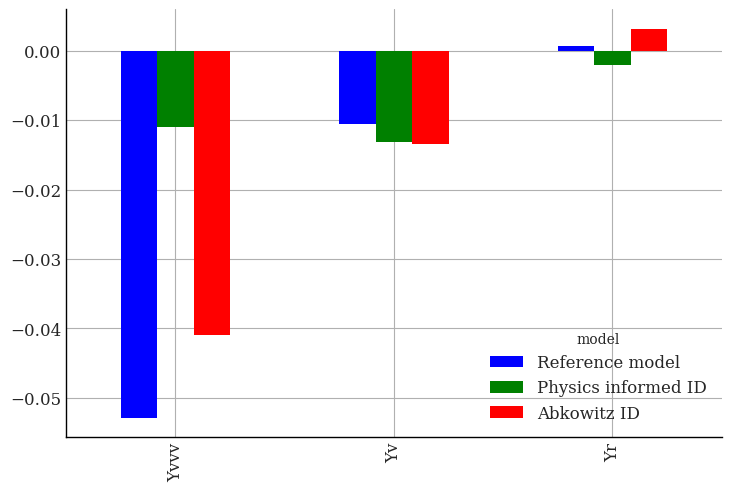

In [20]:
fig,ax=plt.subplots()
df_parameters.groupby(by='dof').get_group('Y').dropna(axis=1).drop(columns='dof').set_index('model').transpose().plot.bar(ax=ax, color=colors)
ax.grid();

In [21]:
df_parameters.groupby(by='dof').get_group('Y').drop(columns='dof').dropna(axis=1)

,model,Yvvv,Yv,Yr
1,Reference model,-0.052838,-0.010511,0.000749
4,Physics informed ID,-0.010906,-0.013080,-0.002091
7,Abkowitz ID,-0.040934,-0.013455,0.003184


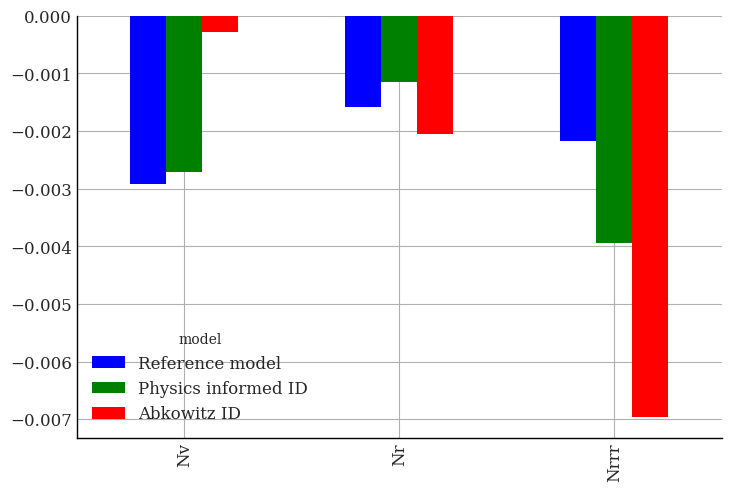

In [22]:
fig,ax=plt.subplots()
df_parameters.groupby(by='dof').get_group('N').dropna(axis=1).drop(columns='dof').set_index('model').transpose().plot.bar(ax=ax, color=colors)
ax.grid();

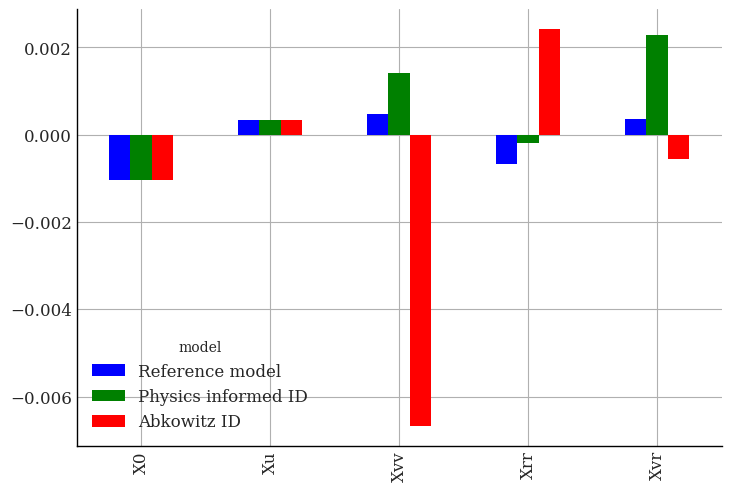

In [23]:
fig,ax=plt.subplots()
df_parameters.groupby(by='dof').get_group('X').dropna(axis=1).drop(columns='dof').set_index('model').transpose().plot.bar(ax=ax, color=colors)
ax.grid();

## Closed loop simulation

In [24]:
def postprocess(df):
    df['V'] = df['U'] = np.sqrt(df['u']**2 + df['v']**2)
    df['beta'] = -np.arctan2(df['v'],df['u'])
    df['beta_deg'] = np.rad2deg(df['beta'])
    df['psi_deg'] = np.rad2deg(df['psi'])
        

In [25]:
if 'thrust' in model.control_keys:
    model.control_keys.remove('thrust')

In [26]:
def simulate_closed_loop(model):
    u0 = data_MDL.iloc[0]['u']
    rev = None
    rudder_rate = 2.32 * np.sqrt(model.ship_parameters["scale_factor"])
    angle_abs = np.rad2deg(data_MDL['delta'].abs().max())
    angle_sign = np.sign(data_MDL.iloc[0:10]['delta'].mean())
    angle = np.round(angle_sign*angle_abs)
    twa=None
    tws=None
    neutral_rudder_angle=0
    thrust_port = data_MDL['thrust_port']
    thrust_stbd = data_MDL['thrust_stbd']
    result_closed_loop = vessel_manoeuvring_models.models.IMO_simulations.zigzag(
            model=model,
            u0=u0,
            rev=rev,
            thrust_port=thrust_port,
            thrust_stbd=thrust_stbd,
            rudder_rate=rudder_rate,
            angle=angle,
            heading_deviation=angle,
            twa=twa,
            tws=tws,
            neutral_rudder_angle=neutral_rudder_angle,
            t_max=data_MDL.index[-1],
        )
    postprocess(result_closed_loop)
    return result_closed_loop

In [27]:
dataframes = {
    'Experiment': data_MDL,
}

In [28]:
for model_name, model in models.items():
    dataframes[model_name] = simulate_closed_loop(model=model)

In [29]:
dataframes['Experiment'] = dataframes['Experiment'].loc[0:dataframes['Reference model'].index[-1]].copy()

[01/31/24 13:31:14] WARNING  /home/maa/dev/VesselManoeuvringModels/vessel_manoeuvring_models/visual ]8;id=185840;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=543067;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             ization/plot.py:127: UserWarning: The figure layout has changed to                    
                             tight                                                                                 
                               plt.tight_layout()                                                                  
                                                                                                                   

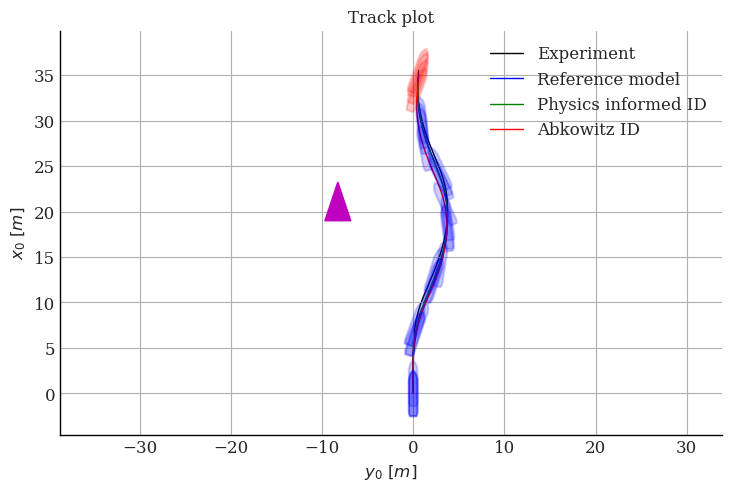

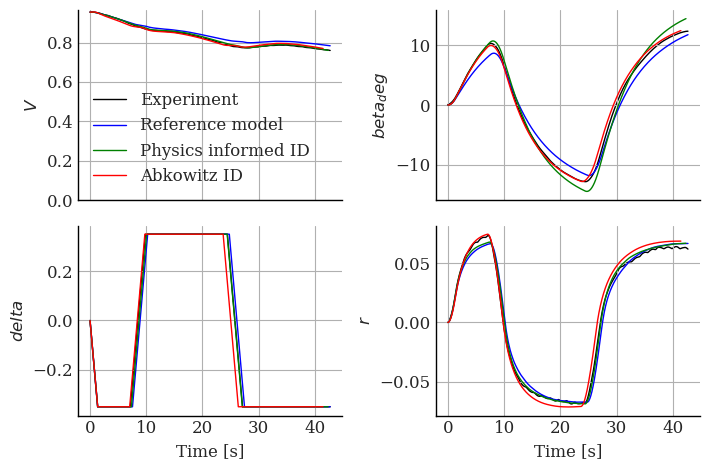

In [30]:
track_plots(dataframes=dataframes,lpp=ship_data['L'],beam=ship_data['B'], styles=styles);
plot(dataframes=dataframes, keys=['V','beta_deg','r','delta'], styles=styles);

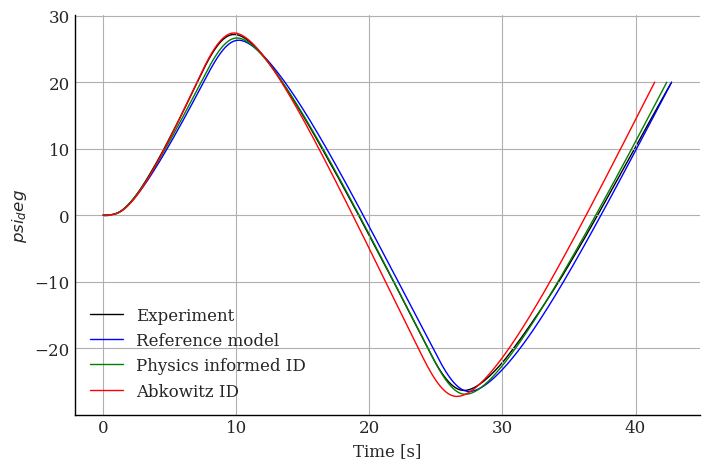

In [31]:
plot(dataframes=dataframes, keys=['psi_deg'], styles=styles, ncols=1);

## Other tests

In [32]:
score_models = ['Physics informed ID', 'Abkowitz ID']


In [33]:
def preprocess(data_MDL):
    data_MDL['V'] = data_MDL['U'] = np.sqrt(data_MDL['u']**2 + data_MDL['v']**2)
    data_MDL['beta'] = -np.arctan2(data_MDL['v'],data_MDL['u'])
    data_MDL['rev'] = data_MDL[['Prop/PS/Rpm','Prop/SB/Rpm']].mean(axis=1)
    data_MDL['twa']=0
    data_MDL['tws']=0
    data_MDL['theta']=0
    data_MDL['q']=0
    data_MDL['phi'] = data_MDL['roll']
    data_MDL['p'] = 0
    data_MDL['q1d'] = 0
    data_MDL['thrust_port'] = data_MDL['Prop/PS/Thrust']
    data_MDL['thrust_stbd'] = data_MDL['Prop/SB/Thrust']

In [34]:
_ = []
ids = tests_ek_smooth_joined['id'].unique()
for model_name in score_models:
    model = models[model_name]
    
    for id in ids:
        
        loader = tests_ek_smooth[str(id)]
        data = loader()
        preprocess(data)
        try:
            s = score(model=model, data=data)
        except:
            print(f"Skipping {id}")
            continue
        
        s = pd.Series(s, name=id)
        s['model'] = model_name       
        _.append(s)
    
df_scores = pd.DataFrame(_)

In [35]:
time_series_meta_data = catalog.load(f"{ship}.time_series_meta_data")

[01/31/24 13:31:17] INFO     Loading data from 'wPCC.time_series_meta_data' (CSVDataSet)...     ]8;id=165402;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=713826;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

In [36]:
steals = [
    'test_type',
    'angle1',
    'ship_speed',
]
for steal in steals:
    df_scores[steal] = time_series_meta_data[steal]

In [37]:
mask = df_scores['test_type'] == 'rodergrundvinkel'
df_scores.loc[mask,'test_type'] = 'yaw rate'

mask = df_scores['test_type'] == 'reference speed'
df_scores.loc[mask,'test_type'] = 'ref. speed'

mask = df_scores['test_type'] == 'zigzag'
df_scores.loc[mask,'Description'] = df_scores.loc[mask].apply(lambda x:f"{x['test_type']}{int(x['angle1'])}/{int(x['angle1'])}", axis=1)
df_scores.loc[~mask,'Description'] = df_scores.loc[~mask,'test_type']
if 'angle1' in df_scores:
    df_scores.drop(columns='angle1',inplace=True)

In [38]:
df_scores

,X_D,Y_D,N_D,model,test_type,ship_speed,Description
22765,0.843338,1.978877,1.929520,Physics informed ID,zigzag,0.96177,zigzag10/10
22770,1.362590,1.910500,1.921518,Physics informed ID,zigzag,0.96177,zigzag10/10
22772,0.951783,3.410690,2.899423,Physics informed ID,zigzag,0.96177,zigzag20/20
22773,0.974933,2.986976,3.259755,Physics informed ID,zigzag,0.96177,zigzag20/20
22765,0.879444,0.808327,1.945084,Abkowitz ID,zigzag,0.96177,zigzag10/10
22770,1.404579,0.893553,1.754411,Abkowitz ID,zigzag,0.96177,zigzag10/10
22772,1.060290,1.216933,3.268325,Abkowitz ID,zigzag,0.96177,zigzag20/20
22773,1.039110,1.050647,3.522439,Abkowitz ID,zigzag,0.96177,zigzag20/20


                    WARNING  /tmp/ipykernel_4787/567131336.py:23: UserWarning: The figure layout    ]8;id=5020;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=684850;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             has changed to tight                                                                  
                               plt.tight_layout()                                                                  
                                                                                                                   

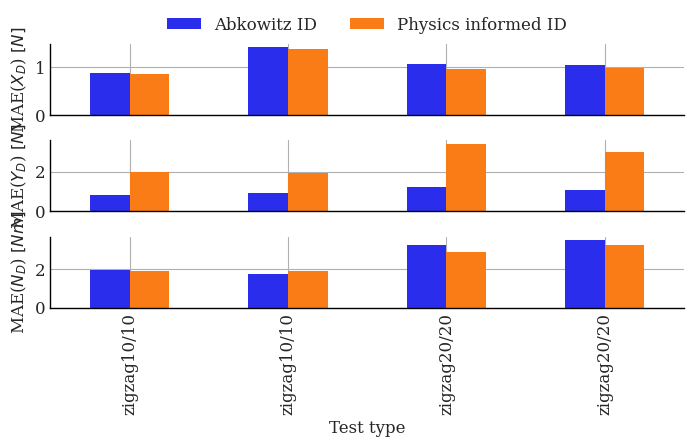

In [39]:
fig,axes=plt.subplots(nrows=3)
dofs = ['X_D','Y_D','N_D']
for dof,ax in zip(dofs,axes):
    df_scores.pivot(columns='model').dropna().plot.bar(x=('Description','Abkowitz ID'), y=dof,ax=ax)

for ax in axes[1:]:
    ax.get_legend().set_visible(False)
    
for ax in axes[0:-1]:
    ax.set_xticklabels([])

for ax in axes:
    ax.set_xlabel('')
    ax.grid(True)
    
axes[0].legend(loc='upper left')
axes[0].set_ylabel(r'MAE($X_D$) $[N]$')
axes[1].set_ylabel(r'MAE($Y_D$) $[N]$')
axes[2].set_ylabel(r'MAE($N_D$) $[Nm]$');
axes[2].set_xlabel('Test type')

fig.axes[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.6), ncol=2)
plt.tight_layout()


In [40]:
fig.savefig(paper.file_path_with_nb_ref("ID_models_mean_average_error.pdf"))